In [1]:
import pandas as pd
import Orange
from orangecontrib.associate.fpgrowth import * 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get the Data

In [2]:
label_creations_df = pd.read_csv(f'data/all_label_creations.csv')

In [3]:
# Some properties are duplicated in the CSV...
label_creations_df.drop_duplicates(inplace=True)
# Sort revisions by properties and timestamps
label_creations_df.sort_values(["property","timestamp"],inplace=True)
# Delete properties with NaN values
label_creations_df = label_creations_df.loc[~label_creations_df.language.isna()]

# Build the dataframe

In [4]:
# Give a position for each label
#
# e.g. 1 means first label created
#      n means n label translated

last_prop,i,position = None,1,[]

for index, row in label_creations_df.copy().iterrows():
    if(row['property'] != last_prop):
        i, last_prop = 1, row['property']
    position.append(i)
    i += 1

label_creations_df['position'] = position

In [5]:
# Create a dataframe given the revision's history for each property
revisions_history_df= pd.pivot_table(data=label_creations_df,
                                     index="property",
                                     columns="position",
                                     values='language',
                                     aggfunc=lambda x: ' '.join(x))

revisions_history_df.fillna('',inplace=True)

In [6]:
# Create dictionnaries to easily encode and decode the languages
languages = label_creations_df.language.unique()
code_to_language = {i:el for i,el in enumerate(languages)}
language_to_code = {el:i for i,el in code_to_language.items()}

In [7]:
def decode_code_list(l):
    return [code_to_language[i] for i in list(l)]

In [8]:
def code_language_list(l):
    return [language_to_code[i] for i in list(l)]

In [9]:
# Convert revisions_history_df to a format accepted by Orange to mine the frequent patterns
history = []
for _,row in revisions_history_df.iterrows():
    history.append([language_to_code[el] for el in row.values if el])
    

### First value

In [10]:
revisions_history_df.loc[:,[1,2]].groupby([1])[2].count().sort_values(ascending=False)/50.26

1
en       89.594111
fr        5.730203
de        2.666136
nl        0.915241
it        0.616793
zh        0.577000
es        0.497413
nb        0.278552
ru        0.218862
sv        0.198965
fi        0.119379
cs        0.099483
pt-br     0.079586
be        0.079586
he        0.079586
pl        0.059690
ko        0.039793
nn        0.039793
fa        0.019897
hi        0.019897
yue       0.019897
ja        0.019897
bn        0.019897
Name: 2, dtype: float64

In [11]:
revisions_history_df.loc[:,[1,2]].groupby([1,2])[2].count().sort_values(ascending=False)/50.26

1    2      
en   fr         27.755671
     de         11.400716
     ru          8.436132
     nl          6.904099
fr   en          5.372065
en   pt          3.461998
     uk          3.263032
     es          3.044170
     sr          2.964584
de   en          2.606446
en   it          2.347791
     da          1.949861
     hu          1.790688
     pl          1.711102
     en-gb       1.711102
     ca          1.691206
     fa          1.532033
     mk          1.273378
     nb          1.134103
     cs          0.895344
     sv          0.855551
     ja          0.835655
     he          0.716275
nl   en          0.676482
zh   en          0.537207
it   en          0.517310
en   ko          0.457620
     fi          0.378034
     zh          0.358138
     zh-hans     0.358138
                  ...    
it   ru          0.019897
ja   en          0.019897
en   af          0.019897
de   fr          0.019897
sv   da          0.019897
yue  en          0.019897
cs   de          0.019897

# Frequent items analysis

In [12]:
min_support = 0.7

In [13]:
# Number of propeties
print("Number of properties: {0}".format(len(history)))

Number of properties: 5126


In [14]:
# Count items 
sum_items = len(list(frequent_itemsets(history, min_support)))                
print("{0} items have a support greater than {1}".format(sum_items,min_support))

31 items have a support greater than 0.7


In [15]:
#iterable = [(support,decode_code_list(itemset)) for itemset, support in frequent_itemsets(history,min_support)]

In [16]:
def get_most_frequent(history, item_len, min_support):
    """
    Input: - history,
           - item_len, lenght of the most frequent items
           - min_support, percentage, if this value is too low you might have performance issues
    
    Output: sorted list of most frequent items
    
    """
    gen = frequent_itemsets(history,min_support)
    decoded_itemsets = [(support,decode_code_list(itemset)) for itemset, support in gen if (len(itemset) == item_len) and (('en','fr') not in decode_code_list(itemset))]
    return list(reversed(sorted(decoded_itemsets)))

In [17]:
exclude = ['en','ar','fr','uk','nl']

In [18]:
def get_most_frequent_2(history, item_len, min_support):
    """
    Input: - history,
           - item_len, lenght of the most frequent items
           - min_support, percentage, if this value is too low you might have performance issues
    
    Output: sorted list of most frequent items
    
    """
    gen = frequent_itemsets(history,min_support)
    decoded_itemsets = [(support,decode_code_list(itemset)) for itemset, support in gen if (len(itemset) == item_len) and (len(set(exclude).intersection(decode_code_list(itemset)))==0)]
    return list(reversed(sorted(decoded_itemsets)))

In [19]:
get_most_frequent(history,1,0.6)

[(5126, ['en']),
 (5080, ['ar']),
 (4988, ['uk']),
 (4988, ['fr']),
 (3884, ['nl']),
 (3546, ['es']),
 (3518, ['mk']),
 (3392, ['de']),
 (3224, ['ru'])]

In [20]:
get_most_frequent_2(history, 2,0.5)

[(2989, ['mk', 'es']),
 (2987, ['mk', 'de']),
 (2959, ['mk', 'ru']),
 (2947, ['es', 'de']),
 (2898, ['de', 'ru']),
 (2881, ['es', 'ru']),
 (2689, ['es', 'ca']),
 (2676, ['mk', 'ca']),
 (2626, ['ca', 'de']),
 (2564, ['ca', 'ru'])]

In [21]:
get_most_frequent(history, 3,0.7)

[(4950, ['en', 'ar', 'fr']),
 (4948, ['en', 'ar', 'uk']),
 (4870, ['en', 'fr', 'uk']),
 (4836, ['ar', 'fr', 'uk']),
 (3866, ['en', 'nl', 'uk']),
 (3862, ['en', 'nl', 'ar']),
 (3848, ['nl', 'ar', 'uk']),
 (3841, ['en', 'nl', 'fr']),
 (3823, ['nl', 'fr', 'uk']),
 (3821, ['ar', 'fr', 'nl'])]

# Association rules analysis

In [22]:
min_support = 0.7

In [23]:
# association of the 4 most commun languages
chinesse = ['zh-hans','zh','zh-mo','zh-my','zh-tw','zh-cn','zh-sg']
latin = ['fr','es','it','pt','ro']
top_latin = ['fr','es','it','pt','ca']
cat = ['es','ca','en']
fr = ['es','ca']
es = ['zh-hans','es']
al = ['es','ca','zh-hans']
middle = ['es','mk','de','ru']#da

In [24]:
min_sup = 0.3
itemset = frozenset(code_language_list(cat))
itemsets_dict = dict(frequent_itemsets(history,min_sup))
rules = association_rules(itemsets_dict,min_sup,itemset = itemset)
decoded_itemsets = [(confidence, decode_code_list(antecedent),decode_code_list(consequent),support) for antecedent,consequent,support,confidence in list(rules)]
list(reversed(sorted(decoded_itemsets)))

[(1.0, ['es', 'ca'], ['en'], 2689),
 (0.8933554817275747, ['en', 'ca'], ['es'], 2689),
 (0.8933554817275747, ['ca'], ['en', 'es'], 2689),
 (0.7583192329385223, ['es'], ['en', 'ca'], 2689),
 (0.7583192329385223, ['en', 'es'], ['ca'], 2689),
 (0.5245805696449474, ['en'], ['es', 'ca'], 2689)]

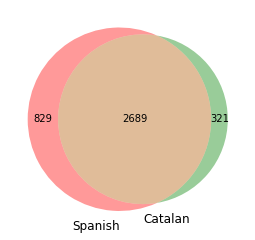

In [25]:
# First way to call the 2 group Venn diagram:
venn2(subsets = (3518-2689, 3010-2689,2689), set_labels = ('Spanish', 'Catalan'))

plt.show()
#plt.savefig('img/catalan')

In [26]:
min_sup = 0.3
itemset = frozenset(code_language_list(fr))
itemsets_dict = dict(frequent_itemsets(history,min_sup))
rules = association_rules(itemsets_dict,min_sup,itemset = itemset)
decoded_itemsets = [(confidence, decode_code_list(antecedent),decode_code_list(consequent),support) for antecedent,consequent,support,confidence in list(rules)]
list(reversed(sorted(decoded_itemsets)))

[(0.8933554817275747, ['ca'], ['es'], 2689),
 (0.7583192329385223, ['es'], ['ca'], 2689)]

In [27]:
min_sup = 0.3
itemset = frozenset(code_language_list(cat))
itemsets_dict = dict(frequent_itemsets(history,min_sup))
rules = association_rules(itemsets_dict,min_sup,itemset = itemset)
decoded_itemsets = [(confidence, decode_code_list(antecedent),decode_code_list(consequent),support) for antecedent,consequent,support,confidence in list(rules)]
list(reversed(sorted(decoded_itemsets)))

[(1.0, ['es', 'ca'], ['en'], 2689),
 (0.8933554817275747, ['en', 'ca'], ['es'], 2689),
 (0.8933554817275747, ['ca'], ['en', 'es'], 2689),
 (0.7583192329385223, ['es'], ['en', 'ca'], 2689),
 (0.7583192329385223, ['en', 'es'], ['ca'], 2689),
 (0.5245805696449474, ['en'], ['es', 'ca'], 2689)]

In [28]:
min_sup = 0.3
itemset = frozenset(code_language_list(al))
itemsets_dict = dict(frequent_itemsets(history,min_sup))
rules = association_rules(itemsets_dict,min_sup,itemset = itemset)
decoded_itemsets = [(confidence, decode_code_list(antecedent),decode_code_list(consequent),support) for antecedent,consequent,support,confidence in list(rules)]
list(reversed(sorted(decoded_itemsets)))

[(0.9554030874785592, ['ca', 'zh-hans'], ['es'], 1671),
 (0.8893028206492816, ['es', 'zh-hans'], ['ca'], 1671),
 (0.7761263353460288, ['zh-hans'], ['es', 'ca'], 1671),
 (0.6214206024544441, ['es', 'ca'], ['zh-hans'], 1671),
 (0.5551495016611295, ['ca'], ['es', 'zh-hans'], 1671),
 (0.4712351945854484, ['es'], ['ca', 'zh-hans'], 1671)]

In [29]:
min_sup = 0.6
itemset = frozenset(code_language_list(middle))
itemsets_dict = dict(frequent_itemsets(history,min_sup))
rules = association_rules(itemsets_dict,0.2)
decoded_itemsets = [(confidence, decode_code_list(antecedent),decode_code_list(consequent),support) for antecedent,consequent,support,confidence in list(rules)]
list(reversed(sorted(decoded_itemsets)))[-10:]

[(0.6067108856808427, ['en'], ['nl', 'mk', 'uk'], 3110),
 (0.6063207179087008, ['en'], ['nl', 'mk', 'ar'], 3108),
 (0.6059055118110236, ['en', 'ar'], ['nl', 'mk', 'fr', 'uk'], 3078),
 (0.6059055118110236, ['ar'], ['nl', 'mk', 'fr', 'uk'], 3078),
 (0.6059055118110236, ['ar'], ['en', 'fr', 'uk', 'nl', 'mk'], 3078),
 (0.6047600468201326, ['en'], ['nl', 'mk', 'ar', 'uk'], 3100),
 (0.6039797112758486, ['en'], ['nl', 'mk', 'fr'], 3096),
 (0.6024190401872805, ['en'], ['nl', 'mk', 'fr', 'uk'], 3088),
 (0.6020288724151385, ['en'], ['fr', 'nl', 'mk', 'ar'], 3086),
 (0.6004682013265704, ['en'], ['ar', 'fr', 'uk', 'nl', 'mk'], 3078)]